In [2]:
# 第一步 获取每一篇文章的网址
    # 1.1、依次获取文章目录页（1-5页）的html文本
        # 1.1.1 实现获取任意网址的html文本的函数
        # 1.1.2 采用该函数依次获取1-5页的html文本
    # 1.2、解析文本获取目录页文章的网址

# 第二步 获取文章详情页的html文本

# 第三步 解析文本获取文章的数据

# 第四步 保存数据到数据库

In [12]:
import requests
import logging
import re
import pymongo
from pyquery import PyQuery as pq
from urllib.parse import urljoin

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s: %(message)s')

BASE_URL = 'https://cuiqingcai.com/archives/'
TOTAL_PAGE = 5

In [13]:
# 1.1、依次获取文章目录页（1-5页）的html文本(网页源代码)
# 1.1.1 实现获取任意网址的html文本的函数
def fetch_text(url):
    try:
        logging.info('开始爬取 %s 网站...', url)
        response = requests.get(url)
        return response.text
    except requests.exceptions.ConnectionError:
        logging.info('爬取 %s 网站错误', url)

In [3]:
# 1.1.2 采用该函数依次获取1-5页的html文本
def scrape_index(page):
    index_url = f'{BASE_URL}/page/{page}' 
    return fetch_text(index_url)

In [4]:
def parse_index(html):
    doc = pq(html)
    links = doc('.post-title-link')
    detail_urls = []
    for link in links.items():
        href = link.attr('href')
        detail_url = urljoin(BASE_URL, href)  
        logging.info('get detail url %s', detail_url)
        detail_urls.append(detail_url)
    return detail_urls

In [19]:
html = fetch_text('http://www.banshujiang.cn/')
print(html)

2024-01-24 20:51:08,222 - INFO: 开始爬取 http://www.banshujiang.cn/ 网站...


<!DOCTYPE html>
<html lang="zh_CN" xmlns:wb="http://open.weibo.com/wb">
<head>
    <title>[搬书匠] - 电子书(EBook)</title>
    <meta charset="UTF-8" />
    <meta name="renderer" content="webkit" /> <!-- 为了告诉360浏览器应该使用极速核了 -->
    <meta http-equiv="X-UA-Compatible" content="IE=edge, chrome=1" /> <!-- 如果安装了GCF，则使用GCF来渲染页面「”chrome=1″」，如果没有安装GCF，>    则使用最高版本的IE内核进行渲染「”IE=edge”」 -->
    <meta name="baidu-site-verification" content="AKra6WroiB" />
    <meta property="wb:webmaster" content="919195fbd9f44369" />
    <link rel="shortcut icon" href="http://image.banshujiang.cn/favicon.ico">
    <link href="https://cdn.bootcdn.net/ajax/libs/twitter-bootstrap/2.2.2/css/bootstrap.min.css" rel="stylesheet" />
    <link href="/asserts/css/e_books.css?release=1705120202416" rel="stylesheet" />
    <script>
        var _hmt = _hmt || [];
        (function() {
            var hm = document.createElement("script");
            hm.src = "https://hm.baidu.com/hm.js?38a41a4c5062c2a88d0e6083f47105ab";
            

<!DOCTYPE html>
<html>
  <head>
    <meta http-equiv="Content-type" content="text/html; charset=utf-8">
    <meta http-equiv="Content-Security-Policy" content="default-src 'none'; style-src 'unsafe-inline'; img-src data:; connect-src 'self'">
    <title>Page not found &middot; GitHub Pages</title>
    <style type="text/css" media="screen">
      body {
        background-color: #f1f1f1;
        margin: 0;
        font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;
      }

      .container { margin: 50px auto 40px auto; width: 600px; text-align: center; }

      a { color: #4183c4; text-decoration: none; }
      a:hover { text-decoration: underline; }

      h1 { width: 800px; position:relative; left: -100px; letter-spacing: -1px; line-height: 60px; font-size: 60px; font-weight: 100; margin: 0px 0 50px 0; text-shadow: 0 1px 0 #fff; }
      p { color: rgba(0, 0, 0, 0.5); margin: 20px 0; line-height: 1.6; }

      ul { list-style: none; margin: 25px 0; padding: 0; }
      li { d
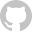
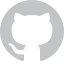

In [18]:
print(html)
links = doc('.post-title-link')
print(links)

In [5]:
def scrape_detail(url):
    return fetch_text(url)

In [6]:
# 第三步 解析文本获取文章的数据  文章的标题，发表时间，阅读次数，本文字数，阅读时长
def parse_detail(html):
    doc = pq(html)
    name = doc('a > h1').text()
    Posted_in = re.search(r'\d{4}-\d{2}-\d{2}', Posted_in).group(0) \
        if Posted_in and re.search(r'\d{4}-\d{2}-\d{2}', Posted_in) else None
    Readings = doc('.fa fa-eye').int()
    Number = doc('.far fa-file-word').int()
    time = doc('.far fa-clock').int()
    return {
        'name ': name,
        'Posted_in': Posted_in,
        'Readings': Readings,
        'Number': Number,
        'time':time
    }


In [11]:
# 定义MongoDB的连接字符串
MONGO_CONNECTION_STRING = 'mongodb://localhost:27017'
MONGO_DB_NAME = 'movies0124'
MONGO_COLLECTION_NAME = 'movies0124'

client = pymongo.MongoClient(MONGO_CONNECTION_STRING)
db = client[MONGO_DB_NAME]
collection = db[MONGO_COLLECTION_NAME]

In [8]:
def save_data(data):
    collection.update_one({
        'name': data.get('name')
        }, {
            '$set': data
        }, upsert=True
    )

In [14]:
def main():
    for page in range(1, TOTAL_PAGE + 1):
        index_html = scrape_index(page)
        detail_urls = parse_index(index_html)  
        for detail_url in detail_urls:         
            detail_html = scrape_detail(detail_url)  
            data = parse_detail(detail_html)
            save_data(data)
            logging.info('saved data successfully, data is: %s', data)

if __name__ == '__main__':
    main()

2024-01-24 20:28:38,510 - INFO: 开始爬取 https://cuiqingcai.com/archives//page/1 网站...
2024-01-24 20:28:39,977 - INFO: 开始爬取 https://cuiqingcai.com/archives//page/2 网站...
2024-01-24 20:28:42,040 - INFO: 开始爬取 https://cuiqingcai.com/archives//page/3 网站...
2024-01-24 20:28:43,038 - INFO: 开始爬取 https://cuiqingcai.com/archives//page/4 网站...
2024-01-24 20:28:43,985 - INFO: 开始爬取 https://cuiqingcai.com/archives//page/5 网站...
